# Learning to trace geometrical paths for faster Ray Tracing

TODO

In [1]:
from collections.abc import Iterator
from typing import Optional

from jaxtyping import jaxtyped
from beartype import beartype as typechecker
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from jaxtyping import Array, Float, UInt, PRNGKeyArray
from tqdm.notebook import trange

from differt2d.geometry import Path, Point, Wall, path_length, ImagePath
from differt2d.scene import Scene

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Problem definition

The goal of our model is to generate all the paths, of a given order, between TX and RX in a 2D scene.

Here, the

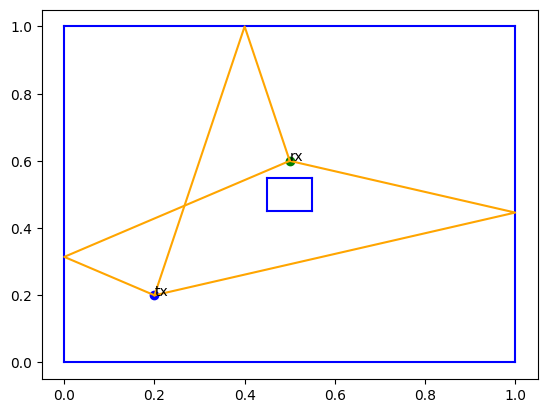

In [2]:
ax = plt.gca()
scene = Scene.square_scene_with_obstacle()
scene.plot(ax)

order = 1

for _, _, path, _ in scene.all_valid_paths(min_order=order, max_order=order, approx=False):
    path.plot(ax)

plt.show()

## Training data generation

In [3]:
key = jax.random.PRNGKey(12345)
key, key_example_scene = jax.random.split(key, 2)


def random_scenes(
    *, key: PRNGKeyArray,
) -> Iterator[tuple[Scene, Float[Array, "2+num_walls*2 2"]]]:
    while True:
        key, key_ratio, key_tx_rx, key_num_walls, key_walls = jax.random.split(key, 5)
        ratio = jax.random.uniform(key_ratio)
        points = jax.random.uniform(key_tx_rx, (2, 2))
        tx = Point(xy=points[0, :])
        rx = Point(xy=points[1, :])
        scene = Scene.square_scene_with_obstacle(ratio=ratio)
        indices = jnp.arange(len(scene.objects), dtype=jnp.uint32)
        num_walls = jax.random.randint(
            key_num_walls, (), minval=0, maxval=len(scene.objects) + 1
        )
        wall_indices = jax.random.choice(
            key_walls, indices, shape=(num_walls,), replace=False
        )
        objects = [scene.objects[wall_index] for wall_index in wall_indices]

        points = jnp.vstack([points, *[obj.xys for obj in objects]])

        yield (
            scene.with_transmitters(tx=tx).with_receivers(rx=rx).with_objects(*objects),
            points,
        )


def samples(
    order: int, *, key: PRNGKeyArray
) -> Iterator[
    tuple[Float[Array, "2+num_walls*2 2"], UInt[Array, "num_paths {order}"]]
]:
    for scene, points in random_scenes(key=key):
        path_candidates = [
            path_candidate
            for _, _, _, path_candidate in scene.all_valid_paths(
                min_order=order, max_order=order, approx=False
            )
        ]

        if len(path_candidates) > 0:
            path_candidates = jnp.stack(path_candidates, dtype=jnp.uint32)
        else:
            path_candidates = jnp.zeros((0, order), dtype=jnp.uint32)

        yield points, path_candidates


scenes = random_scenes(key=key_example_scene)

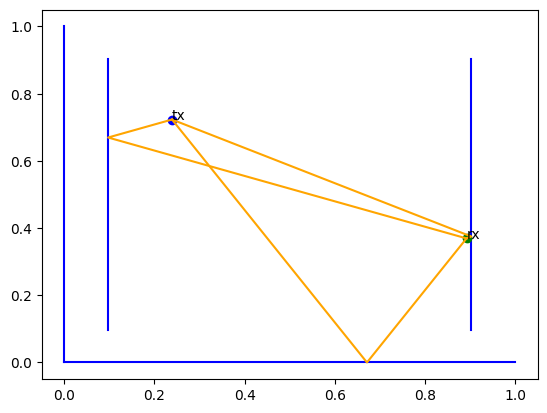

In [4]:
ax = plt.gca()
scene, _ = next(scenes)
scene.plot(ax)

for _, _, path, _ in scene.all_valid_paths(min_order=order, max_order=order, approx=False):
    path.plot(ax)

plt.show()

In [5]:
key, key_model, key_train, key_samples = jax.random.split(key, 4)
key_train_samples, key_test_samples = jax.random.split(key_samples, 2)

train_samples = samples(order=order, key=key_train_samples)
test_samples = samples(order=order, key=key_test_samples)

In [6]:
@jax.jit
@jaxtyped(typechecker=typechecker)
def reward(pred_path_candidate: UInt[Array, " order"], confidence: Float[Array, " "], true_path_candidates: UInt[Array, "num_paths order"]) -> Float[Array, " "]:
    pred_in_true = jax.vmap(jnp.equal, in_axes=(None, 0))(pred_path_candidate, true_path_candidates)
    found_one_path = jnp.any(pred_in_true).astype(jnp.float32)
    
    return (found_one_path - 0.5) * confidence

# Model definition

In [7]:
class Model(eqx.Module):
    # Hyperparameters
    order: int = eqx.field(static=True)
    """The order of the path(s)."""
    hidden_size: int = eqx.field(static=True)
    """The hidden size of the GRU cell."""
    # Layers
    phi: eqx.nn.MLP
    """MLP that is applied to each object in parallel and returns unnormalized log probabilities."""
    dropout: eqx.nn.Dropout
    """Dropout layer to randomly zero some probabilities during training."""
    cell: eqx.nn.GRUCell
    """Recurrent cell."""
    state_2_confidence: eqx.nn.MLP
    """Layer that maps the final state of the recurrent cell to some confidence [0, 1]."""

    def __init__(  # noqa: D107
        self,
        # Hyperparameters
        order: int = 1,
        hidden_size: int = 500,
        *,
        key: PRNGKeyArray,
    ):
        if order < 0:
            raise ValueError(f"Order must be greater or equal to 0, got {order}.")
            
        key1, key2, key3 = jax.random.split(key, 3)

        self.order = order
        self.hidden_size = hidden_size
        self.phi = eqx.nn.MLP(
            in_size=4,
            out_size="scalar",
            width_size=500,
            depth=3,
            key=key1,
        )
        self.dropout = eqx.nn.Dropout()
        self.cell = eqx.nn.GRUCell(
            input_size=1,
            hidden_size=hidden_size,
            key=key2,
        )
        self.state_2_confidence = eqx.nn.MLP(in_size=hidden_size, out_size="scalar",
                                             width_size=500, depth=3, final_activation=jax.nn.sigmoid, key=key3)
    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(  # noqa: D102
        self,
        xys: Float[Array, "two_plus_num_walls_times_two 2"],
        *,
        key: Optional[PRNGKeyArray] = None,
    ) -> tuple[UInt[Array, "{self.order}"], Float[Array, " "]]:
        assert xys.shape[0] >= 2, "Scene must at least have two points: tx and rx."
        
        # [2]
        tx = xys[0, :]
        rx = xys[1, :]

        # [num_walls, 2x2]
        walls = xys[2:, :].reshape(-1, 4)

        indices = jnp.arange(walls.shape[0], dtype=jnp.uint32)

        # Handle empty scene
        if walls.size == 0:
            if self.order == 0:
                return jnp.empty(0, dtype=jnp.uint32), jnp.array(1.0)  # One path candidate of size 0
            else:
                return jnp.empty(self.order, dtype=jnp.uint32), jnp.array(0.0)  # Zero path candidate of size order

        Carry = tuple
        Index = UInt[Array, " "]
        
        def scan_fn(carry: Carry, key: PRNGKeyArray) -> tuple[Carry, Index]:
            state, index = carry
            key_categorical, key_dropout = jax.random.split(key, 2)
            probs = jax.vmap(self.phi)(walls)
            probs = self.dropout(probs, key=key_dropout)
            probs = jnp.where(indices == index, 0, probs)
            index = jax.random.categorical(key=key_categorical, logits=probs)

            state = self.cell(jnp.atleast_1d(index), state)

            return (state, index), index.astype(jnp.uint32)
        
        init_state = jnp.zeros(self.hidden_size)
        init = (init_state, -1)

        (final_state, _), path_candidate = jax.lax.scan(scan_fn, init, xs=jax.random.split(key, self.order))

        confidence = self.state_2_confidence(final_state)

        return path_candidate, confidence

## Loss function definition

In [8]:
def loss(
    model: Model,
    xys: Float[Array, "2+num_walls*2 2"],
    true_path_candidates: UInt[Array, "num_paths order"],
    plot: bool = False,
    num_paths: int = 5,
    *,
    key: PRNGKeyArray,
) -> Float[Array, " "]:
    """
    Compute the loss of the model on a specific input scene.
    """
    pred_path_candidate, confidence = model(xys, key=key)

    if plot:
        order = model.order
        tx = Point(xy=xys[0, :])
        rx = Point(xy=xys[1, :])
        walls = xys[2:].reshape(-1, 2, 2)
        scene = Scene(
            transmitters={"tx": tx},
            receivers={"rx": rx},
            objects=[Wall(xys=wall) for wall in walls],
        )
        ax = plt.gca()
        scene.plot(ax)

        for _, _, path, _ in scene.all_valid_paths(
            min_order=order, max_order=order, approx=False
        ):
            path.plot(ax, color="orange")

        for key in jax.random.split(key, num_paths):
            pred_path_candidate, confidence = model(xys, key=key)
            print(f"{pred_path_candidate = }, {confidence = }")
            objects = [scene.objects[i] for i in pred_path_candidate]
            ImagePath.from_tx_objects_rx(tx, objects, rx).plot(ax, linestyle="--", alpha=float(confidence), color="red")

    r = reward(pred_path_candidate, confidence, true_path_candidates)
    
    return - (r * r)

In [9]:
training_model = Model(key=key_model)
optim = optax.adam(learning_rate=1e-4)

pred_path_candidate = Array([3], dtype=uint32), confidence = Array(0.49551892, dtype=float32)
pred_path_candidate = Array([0], dtype=uint32), confidence = Array(0.49492776, dtype=float32)
pred_path_candidate = Array([2], dtype=uint32), confidence = Array(0.49538863, dtype=float32)
pred_path_candidate = Array([1], dtype=uint32), confidence = Array(0.49519587, dtype=float32)
pred_path_candidate = Array([2], dtype=uint32), confidence = Array(0.49538863, dtype=float32)


Array(-0.06135247, dtype=float32)

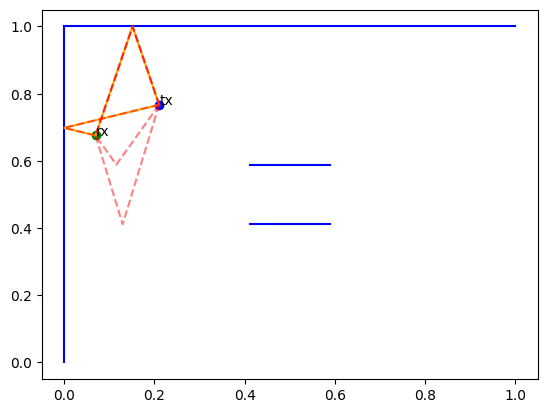

In [10]:
loss(training_model, *next(train_samples), plot=True, key=key)  # Untrained model

In [11]:
def train(
    model: Model,
    train_samples: Iterator,
    test_samples: Iterator,
    optim: optax.GradientTransformation,
    steps: int = 1_000,
    print_every: int = 1_000,
    num_test_samples: int = 100,
    *,
    key: PRNGKeyArray,
):
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: Model,
        opt_state: optax.OptState,
        xys: Float[Array, "2+num_walls*2 2"],
        true_path_candidates: Float[Array, "num_paths order+2 2"],
        *,
        key: PRNGKeyArray,
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(
            model, xys, true_path_candidates, key=key
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    with trange(steps, desc="", unit=" steps", leave=False) as bar:
        for step, (x_train, y_train) in zip(bar, train_samples):
            key, key_step = jax.random.split(key, 2)

            model, opt_state, train_loss = make_step(
                model, opt_state, x_train, y_train, key=key_step
            )
            if (step % print_every) == 0 or (step == steps - 1):
                test_loss = 0
                for _, (x_test, y_test) in zip(
                    range(num_test_samples),
                    test_samples,
                ):
                    key, key_test = jax.random.split(key, 2)
                    test_loss += loss(model, x_test, y_test, key=key_test)
                test_loss /= num_test_samples

                bar.set_description(
                    f"train_loss = {float(train_loss):.1f}, test_loss = {float(test_loss):.1f}"
                )

    return model

In [12]:
training_model = train(training_model, train_samples, test_samples, optim, key=key_train)
inference_model = eqx.nn.inference_mode(training_model)

  0%|          | 0/1000 [00:00<?, ? steps/s]

pred_path_candidate = Array([0], dtype=uint32), confidence = Array(0.99999607, dtype=float32)
pred_path_candidate = Array([0], dtype=uint32), confidence = Array(0.99999607, dtype=float32)
pred_path_candidate = Array([0], dtype=uint32), confidence = Array(0.99999607, dtype=float32)
pred_path_candidate = Array([0], dtype=uint32), confidence = Array(0.99999607, dtype=float32)
pred_path_candidate = Array([0], dtype=uint32), confidence = Array(0.99999607, dtype=float32)


Array(-0.24999803, dtype=float32)

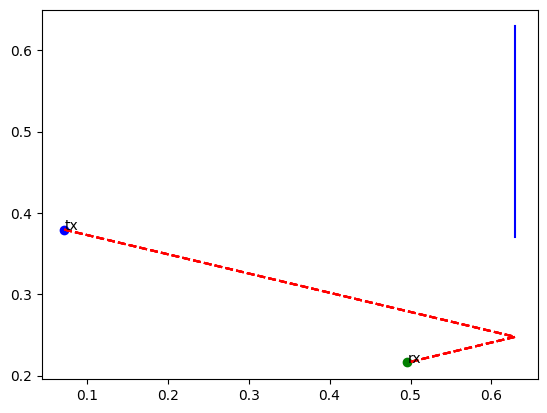

In [19]:
key, key_test_inference = jax.random.split(key, 2)

loss(inference_model, *next(test_samples), plot=True, key=key_test_inference)